# Plot all genotypes/global divergence tree

In order to show where the divergent genotype G viruses cluster with other viruses and where the other genotypes land on the tree, I ran an extra nextstrain tree with all genomes we generated and would like to plot. 

In [455]:
import sys, subprocess, glob, os, shutil, re, importlib,json
from subprocess import call
import imp
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import numpy as np
import pandas as pd
from scipy.special import binom

In [440]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [459]:
def load_tree_json(tree_path):
    
    with open(tree_path, "r") as json_file:
        tree_json = json.load(json_file)
    tree_object=tree_json['tree']
    meta=tree_json['meta']
    json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['div'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

    tree=bt.loadJSON(tree_object,json_translation)
    
    return(tree)

In [442]:
# read in metadata dictionary
def generate_metadata_dictionary(metadata_path):
    metadata = {}

    with open(metadata_path, "r") as infile: 
        for line in infile: 
            if "MuV_genotype" not in line:
                strain = line.split("\t")[0].replace("?","_")  #iqtree will do this replacement
                division = line.split("\t")[6]
                region = line.split("\t")[4]
                country = line.split("\t")[5]
                date = line.split("\t")[3]
                if date == "?":
                    date1 = "XXXX-XX-XX"
                else:
                    date1 = date

                metadata[strain] = {"division":division, "date":date1, "country":country, "region":region}
    metadata["KM597072.1"] = {"division":"reference", "date":"2013-XX-XX", "country":"reference", "region":"Africa"}
    return(metadata)

In [443]:
"""using baltic's subtree function, enumerate the subtree descending from the supplied node"""

def return_subtree(node, tree):
    subtree=tree.subtree(node) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
    if subtree != None:
        subtree.traverse_tree()
        subtree.sortBranches()
        return(subtree)

In [487]:
def plot_full_genome_divergence_tree_triangle(tree,metadata,colors,division_order,output_name, tips_list1,genotype_G_node):
    fig,ax = plt.subplots(figsize=(10,12),facecolor='w')

    divergence = [0,0.01,0.02,0.03,0.04,0.05]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=2 ## default branch width
    tipSize = 40

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.traits['node_attrs']['div']
        y=k.y 

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.traits['node_attrs']['div'] ## get x position of current object's parent
        else:
            xp = x
        
        #### clades are classified as leaf objects
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            
            # first, are you a clade? 
            if isinstance(k, bt.clade):
                if k.numName == "G_clade1":
                    c=colors['G_clade1']
                    s=15
                    z=11
                    label = "North American\nmumps genomes\nshown Figure 2"
                    
                end_x=k.traits['node_attrs']['div'] ## get beginning of triangle
                start_x=k.lastHeight ## get height of last child in clade
                lower_left=[start_x,y-0.0005*len(tree.Objects)]
                upper_left=[start_x,y+0.0005*len(tree.Objects)]
                upper_right=[end_x,y+k.width/3.0]
                lower_right=[end_x,y-k.width/3.0]
    
                clade=plt.Polygon((lower_left,upper_left,upper_right,lower_right),facecolor=c,edgecolor='k',zorder=12) ## define a triangl
                #clade=plt.Polygon(([x,y-0.001*len(tree.Objects)],[x,y+0.001*len(tree.Objects)],[k.lastHeight,y+k.width/3.0],[k.lastHeight,y-k.width/3.0]),facecolor=c,edgecolor='k',zorder=12) ## define a triangle polygon
                ax.add_patch(clade)
                ax.text(x+0.002, y-3, label, fontsize=18)
   
            
            # no? I guess you are a normal leaf then
            else:
                division = metadata[k.numName]['division'].lower().replace(" ","_")
                country = metadata[k.numName]['country'].lower().replace(" ","_")
                region = metadata[k.numName]['region'].lower().replace(" ","_")

                if division == "washington":
                    region = "washington"
                elif "asia" in region or "japan_korea" in region or "china" in region:
                    region = "asia"
                else:
                    region = region

                c=colors[region]
            
                if metadata[k.numName]['division'].lower() == "reference":
                    s=0
                    z=0
                elif division == "washington": 
                    s=tipSize ## tip size can be fixed
                    z=12
                else:
                    s=tipSize
                    z=11
                
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=z) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            
            if k == genotype_G_node:
                label = "Genotype\n   G"
                ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
                ax.scatter(x,y,s=100,facecolor="black",edgecolor='none',zorder=z) ## plot a circle at the genotype G marker
                ax.text(x-0.008, y-6, label, fontsize=18)
                
            else:
                # this is the vertical line
                ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
        # this is the horizonal lines connecting the tips to other parts of the tree
        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
        #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("Usa","USA").replace("And","and"), markersize = 12)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

    ax.set_xlim(0,0.012)
    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticks(divergence)
    ax.set_xlabel("\nDivergence (substitutions per site)", fontsize=24)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.05, 0.02], loc=3,prop={'size': 24}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name)

    plt.show()

# Run 

In Figtree, I manually rooted the tree (midpoint) and ordered the nodes to be in descending order. Then, export as newick and check "export as displayed" or something like that. 

In [488]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [489]:
# try instead, clustering into regions and plotting it that way; we could do: west, 2 midwests, 2 souths, northeast

colors = {"washington":"#2664A5",
          "north_america":"#93B2D2",
          "asia":"#EEA160",
          "china":"#5CA7A4",
          "oceania":"#CF7E86",
         "europe":"#5CA7A4",#"#544370", 
         "africa":"#B2313D",
         "G_clade1":"#93B2D2",
         "G_clade2":"#93B2D2"}

uncertainty_color = "#B9B9B9"


division_order = ["washington","north_america","africa","europe","asia","oceania"]

In [490]:
tree_path = "../auspice/mumps_global.json"
metadata_path = "../auspice/metadata.tsv"
output_name = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/global-all-genomes-divergence-tree-"+current_date+".pdf"

In [491]:
all_figure2 = ["Massachusetts.USA/26.15/1/G","NewJersey.USA/49.14/G","Virginia.USA/51.14/G","Pennsylvania.USA/51.14/G","NewYork/10.14/2/G","NewYork.USA/51.14/G","MountIsa.AUS/10.17/G","BritishColumbia.CAN/34.16/3/G","BritishColumbia.CAN/33.16/3/G","BritishColumbia.CAN/36.16/G","BritishColumbia.CAN/16.16/4/G","BritishColumbia.CAN/28.16/5/G","BritishColumbia.CAN/31.16/2/G","BritishColumbia.CAN/17.16/G","BritishColumbia.CAN/27.16/3/G","BritishColumbia.CAN/29.16/4/G","BritishColumbia.CAN/24.16/3/G","BritishColumbia.CAN/25.16/3/G","BritishColumbia.CAN/26.16/5/G","BritishColumbia.CAN/26.16/1/G","BritishColumbia.CAN/28.16/6/G","BritishColumbia.CAN/29.16/5/G","BritishColumbia.CAN/28.16/1/G","BritishColumbia.CAN/25.16/5/G","BritishColumbia.CAN/21.16/2/G","BritishColumbia.CAN/21.16/6/G","BritishColumbia.CAN/27.16/7/G","BritishColumbia.CAN/29.16/3/G","BritishColumbia.CAN/22.16/1/G","BritishColumbia.CAN/30.16/3/G","BritishColumbia.CAN/21.16/3/G","BritishColumbia.CAN/24.16/4/G","BritishColumbia.CAN/31.16/4/G","BritishColumbia.CAN/29.16/6/G","BritishColumbia.CAN/42.16/G","BritishColumbia.CAN/24.16/7/G","BritishColumbia.CAN/23.16/2/G","BritishColumbia.CAN/24.16/1/G","BritishColumbia.CAN/30.16/2/G","BritishColumbia.CAN/24.16/5/G","BritishColumbia.CAN/30.16/1/G","BritishColumbia.CAN/31.16/1/G","BritishColumbia.CAN/27.16/_/_","BritishColumbia.CAN/13.16/G","BritishColumbia.CAN/33.16/2/G","BritishColumbia.CAN/20.16/1/G","BritishColumbia.CAN/18.16/G","BritishColumbia.CAN/28.16/4/G","BritishColumbia.CAN/27.16/4/G","BritishColumbia.CAN/19.16/3/G","BritishColumbia.CAN/18.16/3/G","BritishColumbia.CAN/19.16/2/G","BritishColumbia.CAN/22.16/2/G","BritishColumbia.CAN/24.16/2/G","BritishColumbia.CAN/18.16/4/G","BritishColumbia.CAN/18.16/2/G","BritishColumbia.CAN/19.16/5/G","BritishColumbia.CAN/23.16/1/G","BritishColumbia.CAN/19.16/1/G","BritishColumbia.CAN/21.16/4/G","Illinois.USA/26.15/2/G","Missouri.USA/29.15/FH114/G","Wisconsin.USA/42.15/FH115/G","Wisconsin.USA/2.16/FH118/G","Massachusetts.USA/12.16/5/G","Michigan.USA/4.16/G","Ohio.USA/19.16/FH119/G","Wisconsin.USA/19.16/FH121/G","Wisconsin.USA/24.16/FH120/G","Massachusetts.USA/21.16/1/G","Louisiana.USA/29.17/G","Texas.USA/27.17/G","Massachusetts.USA/46.16/4/G","Massachusetts.USA/46.16/2/G","Texas.USA/18.17/G","Texas.USA/15.17/G","Massachusetts.USA/45.16/7/G","Massachusetts.USA/45.16/5/G","Ohio.USA/46.17/FH157/G","NorthCarolina.USA/11.17/FH136/G","Alabama.USA/50.17/FH156/G","BritishColumbia.CAN/8.17/3/G","Wisconsin.USA/42.15/FH116/G","Wisconsin.USA/46.15/FH117/G","Wisconsin.USA/51.15/FH163/G","Massachusetts.USA/19.16/6/G","Massachusetts.USA/16.16/12/G","Pennsylvania.USA/19.16/G","NewHampshire.USA/8.16/1/G","Massachusetts.USA/10.16/14/G","Massachusetts.USA/13.16/3/G","Massachusetts.USA/11.16/6/G","Massachusetts.USA/14.16/3/G","Massachusetts.USA/11.16/2/G","Massachusetts.USA/9.16/3/G","Massachusetts.USA/11.16/1/G","Massachusetts.USA/10.16/5/G","Massachusetts.USA/10.16/6/G","Massachusetts.USA/9.16/2/G","Massachusetts.USA/12.16/1/G","Massachusetts.USA/13.16/2/G","Massachusetts.USA/10.16/10/G","Washington.USA/4.17/FH48/G","Washington.USA/12.17/FH76/G","Springdale_745/2016/G","Springdale_754/2016/G","Springdale_730/2016/G","Arkansas.USA/47.16/G","Arkansas.USA/41.16/G","Arkansas.USA/5.17/G","Ohio.USA/2.17/FH128/G","Ohio.USA/7.17/FH130/G","Arkansas.USA/49.16/G","Arkansas.USA/50.16/G","Arkansas.USA/52.16/G","Washington.USA/16.17/FH63/G","Washington.USA/17.17/FH38/G","Washington.USA/16.17/FH36/G","Arkansas.USA/12.17/G","Arkansas.USA/48.16/G","Arkansas.USA/13.17/G","Arkansas.USA/51.16/G","Arkansas.USA/43.16/G","Arkansas.USA/44.16/G","Kansas.USA/8.17/G","Wisconsin.USA/50.16/FH126/G","Washington.USA/18.17/FH147/G","Washington.USA/15.17/FH146/G","Washington.USA/2.17/FH84/G","Washington.USA/11.17/FH143/G","Washington.USA/3.17/FH62/G","Washington.USA/3.17/FH67/G","Washington.USA/12.17/FH144/G","Washington.USA/7.17/FH15/G","Arkansas.USA/46.16/G","BritishColumbia.CAN/18.17/2/G","Washington.USA/50.16/FH3/G","Washington.USA/5.17/FH27/G","Washington.USA/4.17/FH68/G","Washington.USA/51.16/FH41/G","Washington.USA/1.17/FH7/G","Washington.USA/2.17/FH47/G","Arkansas.USA/45.16/G","Washington.USA/6.17/FH12/G","Washington.USA/5.17/FH72/G","Washington.USA/29.17/FH83/G","Washington.USA/19.17/FH80/G","Arkansas.USA/38.16/G","Arkansas.USA/40.16/G","Washington.USA/1.17/FH29/G","Washington.USA/11.17/FH56/G","Washington.USA/3.17/FH24/G","Washington.USA/6.17/FH13/G","Washington.USA/4.17/FH49/G","Washington.USA/49.16/FH45/G","Washington.USA/50.16/FH2/G","Washington.USA/15.17/FH20/G","Washington.USA/20.17/FH73/G","Washington.USA/21.17/FH69/G","Washington.USA/17.17/FH39/G","Washington.USA/20.17/FH148/G","Washington.USA/23.17/FH150/G","Washington.USA/30.17/FH32/G","Washington.USA/23.17/FH149/G","Washington.USA/1.17/FH160/G","Washington.USA/50.16/FH4/G","Washington.USA/7.17/FH106/G","Washington.USA/12.17/FH97/G","Washington.USA/50.16/FH33/G","Washington.USA/2.17/FH66/G","Washington.USA/49.16/FH55/G","Washington.USA/48.16/FH1/G","Washington.USA/49.16/FH158/G","Washington.USA/4.17/FH60/G","Washington.USA/1.17/FH77/G","Washington.USA/10.17/FH43/G","Washington.USA/9.17/FH42/G","Washington.USA/52.16/FH75/G","Washington.USA/1.17/FH5/G","Washington.USA/2.17/FH26/G","Washington.USA/5.17/FH10/G","Washington.USA/51.16/FH46/G","Washington.USA/5.17/FH11/G","Washington.USA/4.17/FH103/G","Washington.USA/20.17/FH82/G","Washington.USA/20.17/FH81/G","Washington.USA/7.17/FH61/G","Washington.USA/2.17/FH21/G","Washington.USA/7.17/FH166/G","Washington.USA/5.17/FH161/G","Washington.USA/5.17/FH30/G","Washington.USA/2.17/FH22/G","Washington.USA/5.17/FH162/G","Washington.USA/12.17/FH34/G","Washington.USA/2.17/FH23/G","Washington.USA/3.17/FH59/G","Washington.USA/4.17/FH70/G","Washington.USA/1.17/FH65/G","Washington.USA/5.17/FH9/G","Washington.USA/3.17/FH25/G","Washington.USA/22.17/FH74/G","Washington.USA/16.17/FH152/G","Washington.USA/10.17/FH52/G","Washington.USA/4.17/FH71/G","Washington.USA/52.16/FH28/G","Washington.USA/2.17/FH54/G","Washington.USA/1.17/FH6/G","Washington.USA/12.17/FH57/G","Washington.USA/2.17/FH58/G","Washington.USA/1.17/FH8/G","Washington.USA/8.17/FH17/G","Washington.USA/9.17/FH31/G","Washington.USA/9.17/FH18/G","Washington.USA/50.16/FH64/G","Washington.USA/6.17/FH14/G","Washington.USA/6.17/FH105/G","Washington.USA/8.17/FH19/G","Washington.USA/12.17/FH35/G","Massachusetts.USA/20.16/2/G","Massachusetts.USA/37.15/1/G","Ohio.USA/2.18/FH102/G","Massachusetts.USA/46.16/5/G","Montana.USA/11.16/G","Massachusetts.USA/52.16/G","Ontario.CAN/09.17/4/G","Ontario.CAN/06.17/1/G","Ontario.CAN/12.17/4/G","Ontario.CAN/09.17/9/G","Ontario.CAN/06.17/3/G","Ontario.CAN/06.17/4/G","BritishColumbia.CAN/8.17/5/G","BritishColumbia.CAN/8.17/2/G","BritishColumbia.CAN/8.17/8/G","Washington.USA/11.17/FH96/G","Ontario.CAN/07.17/1/G","Ontario.CAN/09.17/2/G","Ontario.CAN/08.17/2/G","Ontario.CAN/08.17/3/G","Ontario.CAN/13.17/2/G","BritishColumbia.CAN/11.16/G","Massachusetts.USA/13.16/4/G","Rockhampton.AUS/41.16/G","Washington.USA/16.17/FH79/G","Missouri.USA/15.17/FH135/G","Manitoba.CAN/43.16/11/G","Manitoba.CAN/44.16/15/G","Manitoba.CAN/43.16/5/G","Manitoba.CAN/47.16/4/G","Washington.USA/19.17/FH53/G","Ontario.CAN/12.17/5/G","Ontario.CAN/09.17/3/G","Ontario.CAN/09.17/7/G","Ontario.CAN/04.17/1/G","Ontario.CAN/12.17/3/G","Ontario.CAN/09.17/8/G","Ontario.CAN/06.17/2/G","Ontario.CAN/09.17/6/G","Ontario.CAN/12.17/2/G","Ontario.CAN/12.17/1/G","Washington.USA/17.17/FH40/G","Ontario.CAN/09.17/10/G","Ontario.CAN/13.17/1/G","Ontario.CAN/09.17/1/G","Massachusetts.USA/27.16/1/G","Massachusetts.USA/30.16/1/G","Massachusetts.USA/45.16/2/G","Massachusetts.USA/45.16/4/G","Massachusetts.USA/50.16/1/G","Massachusetts.USA/43.16/1/G","Massachusetts.USA/45.16/3/G","Massachusetts.USA/42.16/1/G","Massachusetts.USA/45.16/1/G","Massachusetts.USA/46.16/7/G","Massachusetts.USA/44.16/1/G","Massachusetts.USA/43.16/2/G","Massachusetts.USA/39.16/1/G","Massachusetts.USA/46.16/1/G","Massachusetts.USA/46.16/6/G","Massachusetts.USA/10.16/3/G","Massachusetts.USA/17.16/7/G","Massachusetts.USA/12.16/3/G","Massachusetts.USA/10.16/13/G","Massachusetts.USA/8.16/1/G","Massachusetts.USA/19.16/10/G","Massachusetts.USA/11.16/3/G","Massachusetts.USA/11.16/5/G","Massachusetts.USA/16.16/13/G","Massachusetts.USA/17.16/1/G","Massachusetts.USA/17.16/10/G","Massachusetts.USA/17.16/11/G","Massachusetts.USA/10.16/2/G","Massachusetts.USA/16.16/1/G","Massachusetts.USA/12.16/4/G","Massachusetts.USA/22.16/2/G","Massachusetts.USA/17.16/8/G","Massachusetts.USA/11.16/4/G","Massachusetts.USA/8.16/3/G","Massachusetts.USA/10.16/7/G","Massachusetts.USA/10.16/8/G","Massachusetts.USA/12.16/2/G","Massachusetts.USA/14.16/1/G","Massachusetts.USA/13.16/1/G","Massachusetts.USA/16.16/4/G","Massachusetts.USA/9.16/4/G","Massachusetts.USA/8.16/5/G","Massachusetts.USA/10.16/4/G","Massachusetts.USA/10.16/9/G","Massachusetts.USA/10.16/1/G","Massachusetts.USA/8.16/2/G","Massachusetts.USA/16.16/9/G","Massachusetts.USA/14.16/2/G","Massachusetts.USA/10.16/12/G","Massachusetts.USA/8.16/6/G","Massachusetts.USA/9.16/1/G","Massachusetts.USA/17.16/12/G","Massachusetts.USA/15.16/2/G","Massachusetts.USA/15.16/1/G","Massachusetts.USA/17.16/2/G","Massachusetts.USA/17.16/6/G","Massachusetts.USA/19.16/1/G","Massachusetts.USA/17.16/3/G","Massachusetts.USA/16.16/2/G","Massachusetts.USA/16.16/5/G","Massachusetts.USA/16.16/16/G","Massachusetts.USA/19.16/7/G","Massachusetts.USA/17.16/13/G","Massachusetts.USA/19.16/8/G","Massachusetts.USA/18.16/2/G","Massachusetts.USA/19.16/9/G","Massachusetts.USA/16.16/6/G","Massachusetts.USA/17.16/4/G","Massachusetts.USA/16.16/14/G","Massachusetts.USA/16.16/7/G","Massachusetts.USA/16.16/15/G","Massachusetts.USA/19.16/3/G","Massachusetts.USA/16.16/19/G","Massachusetts.USA/16.16/3/G","Massachusetts.USA/18.16/3/G","Massachusetts.USA/16.16/18/G","Massachusetts.USA/18.16/1/G","Massachusetts.USA/22.16/1/G","Massachusetts.USA/16.16/10/G","Massachusetts.USA/20.16/1/G","Massachusetts.USA/19.16/5/G","Massachusetts.USA/17.16/9/G","Massachusetts.USA/19.16/2/G","Massachusetts.USA/18.16/4/G","Massachusetts.USA/19.16/4/G","Massachusetts.USA/25.17/4/G","Massachusetts.USA/25.17/3/G","Massachusetts.USA/22.17/3/G","Massachusetts.USA/13.17/2/G","Massachusetts.USA/22.17/6/G","Massachusetts.USA/26.17/G","Massachusetts.USA/24.17/3/G","Massachusetts.USA/22.17/G","Massachusetts.USA/25.17/2/G","Massachusetts.USA/22.17/5/G","Massachusetts.USA/21.17/2/G","Massachusetts.USA/25.17/7/G","Massachusetts.USA/22.17/8/G","Georgia.USA/13.17/G","Massachusetts.USA/24.17/G","Massachusetts.USA/22.17/2/G","Massachusetts.USA/24.17/4/G","Massachusetts.USA/19.17/G","Massachusetts.USA/19.17/3/G","Massachusetts.USA/25.17/G","Massachusetts.USA/24.17/2/G","Massachusetts.USA/21.17/G","Massachusetts.USA/22.17/4/G","Massachusetts.USA/19.17/4/G","Massachusetts.USA/16.16/17/G","Massachusetts.USA/16.16/8/G","Massachusetts.USA/19.16/11/G","Massachusetts.USA/22.16/3/G","NewHampshire.USA/40.16/G","Missouri.USA/32.16/FH88/G","Massachusetts.USA/33.16/1/G","Massachusetts.USA/27.16/2/G","Indiana.USA/48.16/G","Washington.USA/17.17/FH37/G","Missouri.USA/2.17/FH127/G","Missouri.USA/46.16/FH124/G","Washington.USA/5.17/FH50/G","Missouri.USA/46.16/FH123/G","Missouri.USA/7.17/FH129/G","Missouri.USA/50.16/FH125/G","Kansas.USA/13.17/2/G","Indiana.USA/1.17/G","Indiana.USA/49.16/G","Illinois.USA/14.17/G","Missouri.USA/19.17/FH140/G","NorthDakota.USA/15.17/G","NorthDakota.USA/14.17/G","NorthDakota.USA/9.17/G","Massachusetts.USA/14.17/2/G","Kansas.USA/10.17/G","Kansas.USA/8.17/4/G","Kansas.USA/9.17/2/G","Kansas.USA/15.17/G","Washington.USA/6.17/FH51/G","Alabama.USA/11.17/FH90/G","Alabama.USA/19.17/FH92/G","Missouri.USA/24.17/FH165/G","Missouri.USA/33.17/FH155/G","Massachusetts.USA/8.17/G","Massachusetts.USA/14.17/G","Missouri.USA/41.16/FH122/G","Alabama.USA/7.17/FH164/G","Alabama.USA/15.17/FH139/G","Wisconsin.USA/19.17/FH141/G","Missouri.USA/28.17/FH101/G","Wisconsin.USA/15.17/FH89/G","Missouri.USA/11.17/FH133/G","Massachusetts.USA/23.17/G","Illinois.USA/11.17/G","Massachusetts.USA/22.17/9/G","Massachusetts.USA/17.17/G","Massachusetts.USA/25.17/6/G","Massachusetts.USA/25.17/5/G","Washington.USA/19.17/FH44/G","Missouri.USA/15.17/FH138/G","Missouri.USA/15.17/FH134/G","Ohio.USA/11.17/FH132/G","Wisconsin.USA/15.17/FH137/G","Ontario.CAN/37.09/G","BritishColumbia.CAN/14.11/2/G","New_York.USA/53.09/3","New_York.USA/40.09/1","Ontario.CAN/38.09/2/G","Ontario.CAN/40.09/1/G","Ontario.CAN/50.09/1/G","New_York.USA/01.10","New_York.USA/40.09/4","Ontario.CAN/50.09/3/G","California.USA/40.11/G","NewJersey.USA/16.14/2/G","Indiana.USA/5.14/G","Wisconsin.USA/20.14/FH111/G","Wisconsin.USA/16.14/FH110/G","Wisconsin.USA/29.14/FH113/G","Wisconsin.USA/20.14/FH86/G","Wisconsin.USA/16.14/FH85/G","Wisconsin.USA/24.14/FH112/G","NewYork.USA/10.14/3/G","NewYork.USA/10.14/2/G","NewYork.USA/8.14/G","NewYork.USA.USA/51.14/G","Ohio.USA/13.14/10/G","Ohio.USA/13.14/6/G","Ohio.USA/12.14/9/G","Michigan.USA/12.14/G","Ohio.USA/11.14/2/G","Ohio.USA/13.14/7/G","Ohio.USA/16.14/2/G","Ohio.USA/16.14/1/G", "Wisconsin.USA/7.07/FH107/G","Wisconsin.USA/11.07/FH108/G","Wisconsin.USA/7.07/FH154/G","Wisconsin.USA/11.07/FH109/G","Ontario.CAN/04.10/G","Ontario.CAN/08.17/1/G","Massachusetts.USA/12.17/G","Massachusetts.USA/5.17/G","Georgia.USA/2.17/G","Massachusetts.USA/18.17/G","Massachusetts.USA/22.17/7/G","Massachusetts.USA/23.17/2/G","Massachusetts.USA/19.17/2/G", "Wisconsin.USA/15.06/FH131/G","Iowa.USA/06/G","Wisconsin.USA/28.06/FH159/G","Wisconsin.USA/41.06/FH153/G","Wisconsin.USA/37.06/FH93/G","Wisconsin.USA/41.06/FH99/G"]

for k in tree.Objects: 
    if k.branchType == "node":
        if k.leaves == set(all_G):
            genotype_G_node = k

            
for k in tree.Objects: 
    if k.branchType == "node":
        if k.leaves == set(all_figure2):
            ancestor = k
            print(k)
            tree.collapseSubtree(ancestor,'G_clade1',widthFunction=lambda x:len(x.leaves)/10)

# check to make sure we did collapse a clade
for k in tree.Objects: 
    if isinstance(k, bt.clade):
        print("clade")

clade


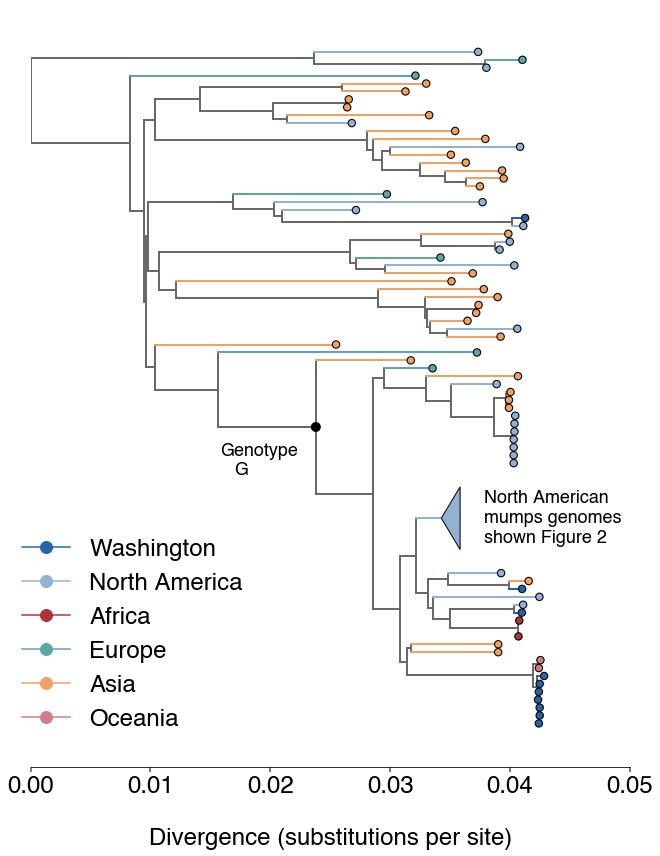

In [492]:
output_name = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/eLife-submission-2020-01-08/resubmission-2021-03/figures/individual-PDFs/global-all-genomes-divergence-tree-triangles-"+current_date+".pdf"
plot_full_genome_divergence_tree_triangle(tree,metadata,colors,division_order,output_name, G_clade1,genotype_G_node)

## pull out the subtrees for the divergent Washington sequences 

In [493]:
"""using baltic's subtree function, enumerate the subtree descending from the supplied node"""

def return_subtree(node, tree):
    subtree=tree.subtree(node) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
    if subtree != None:
        subtree.traverse_tree()
        subtree.sortBranches()
        return(subtree)

In [494]:
def plot_subtree(tree,metadata,colors,division_order,output_name, width, height):
    fig,ax = plt.subplots(figsize=(width, height),facecolor='w')

    divergence = [0,0.01,0.02,0.03,0.04,0.05]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=2 ## default branch width


    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
            
            division = metadata[k.numName]['division'].lower().replace(" ","_")
            country = metadata[k.numName]['country'].lower().replace(" ","_")
            region = metadata[k.numName]['region'].lower().replace(" ","_")
            
            if k.numName == "KM597072.1":
                label = ""
            else:
                label = k.numName
            
            if division == "washington":
                region = "washington"
            elif "asia" in region or "japan_korea" in region:
                region = "asia"
            else:
                region = region
            
            c=colors[region]
            
            if metadata[k.numName]['division'].lower() == "reference":
                s = 0
            elif division == "washington": 
                s=45 ## tip size can be fixed
            else:
                s=45

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.text(x + 0.001,y-0.2,label, fontsize=14,zorder=13)

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
        #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
#     for key in division_order:
#         marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("Usa","USA").replace("And","and"), markersize = 8)
#         han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    #ax.set_xlim(0.035,0.06)
#     ax.set_ylim(-10,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=0,size=0)
#     ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

#     ax.set_xticks(divergence)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
#     ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.04, 0.1], loc=3,prop={'size': 20}, facecolor='w')

    plt.tight_layout()
    #plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name)

    plt.show()

In [495]:
target_leaves1 = ["Dunedin.NZL/32.17/G","NewPlymouth.NZL/30.17/G","Washington.USA/19.17/FH100/G","Washington.USA/9.17/FH16/G","Washington.USA/14.17/FH145/G","Washington.USA/5.17/FH104/G","Washington.USA/8.17/FH142/G","Washington.USA/11.17/FH95/G","Washington.USA/14.17/FH98/G"]
target_leaves2 = ["Ontario.CAN/13.10/G","31170187","Washington.USA/12.17/FH78/G","BritishColumbia.CAN/28.16/3/G","Washington.USA/28.17/FH151/G","Massachusetts.USA/37.16/1/G","Gabon/9.13/2/G","KM597072.1","Gabon/13/2/G"]
target_leaves3 = ["Washington.USA/9.17/FH94/K","Massachusetts.USA/24.17/5/K"]

subtrees = []
subtree_y_values = []

for k in tree.Objects: 
    if k.branchType == "node":
        if k.leaves == set(target_leaves1):
            subtree1 = return_subtree(k, tree)
            subtrees.append(subtree1)
            subtree_y_values.append(k.y)
        if k.leaves == set(target_leaves2):
            subtree2 = return_subtree(k,tree)
            subtrees.append(subtree2)
            subtree_y_values.append(k.y)
            
        if k.leaves == set(target_leaves3):
            subtree3 = return_subtree(k,tree)
            subtrees.append(subtree3)
            subtree_y_values.append(k.y)
            
print(subtree1,subtree2, subtree3)            

<baltic.tree object at 0x7f81fe642128> <baltic.tree object at 0x7f81fea68518> <baltic.tree object at 0x7f81ff75af28>


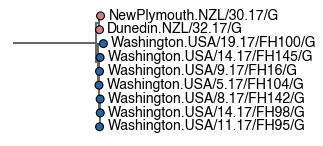

In [425]:
output_name = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/eLife-submission-2020-01-08/resubmission-2021-03/figures/individual-PDFs/NZ-cluster-2021-03-05.pdf"
width = 5
height = 2.5

plot_subtree(subtree1,metadata,colors,division_order,output_name, width, height)

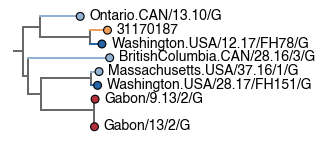

In [426]:
output_name = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/eLife-submission-2020-01-08/resubmission-2021-03/figures/individual-PDFs/other-2G-2021-03-05.pdf"
width = 5
height = 2.5

plot_subtree(subtree2,metadata,colors,division_order,output_name, width, height)

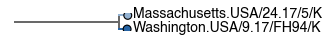

In [437]:
output_name = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/eLife-submission-2020-01-08/resubmission-2021-03/figures/individual-PDFs/K-cluster-2021-03-05.pdf"
width = 5
height = 1

plot_subtree(subtree3,metadata,colors,division_order,output_name, width, height)